In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
import torch
from torch.utils.data import ConcatDataset
from typing import List
from model import FreckerDataSet

def load_frecker_datasets(dataset_base_dir: str, iter_now: int, training_dataset_cross: int) -> ConcatDataset:
    """
    加载并合并多个Frecker数据集文件
    
    Args:
        dataset_base_dir (str): 数据集基础目录
        iter_now (int): 当前迭代次数
        training_dataset_cross (int): 跨数据集训练的数量
        
    Returns:
        ConcatDataset: 合并后的数据集
    """
    datafiles = []
    if iter_now == 0:
        datafiles.append(f"{dataset_base_dir}/1.h5")
    else:
        for i in range(
            max(1, iter_now - training_dataset_cross),
            iter_now + 2
        ):
            datafiles.append(f"{dataset_base_dir}/{i}.h5")
    
    datasets = [FreckerDataSet(x) for x in datafiles]
    dataset = ConcatDataset(datasets)
    print(f"加载了 {len(dataset)} 个样本")
    
    return dataset

In [4]:
def select_game_snapshot(dataset, player = 0):
    """
    从数据集中提取每个样本的[0][12:15]切片并拼接成矩阵
    
    Args:
        dataset: 包含多个游戏快照的数据集
        
    Returns:
        torch.Tensor: 拼接后的矩阵，形状为(N, 3, 8, 8)
    """
    slices = []
    for i in range(len(dataset)):
        # 获取每个样本的第0个元素(状态张量)的第12-14通道
        if player == 0:
            slice_data = dataset[i][0][12:14]
        elif player == 1:
            slice_data = dataset[i][0][12]
        elif player == 2:
            slice_data = dataset[i][0][13]
        else:
            r = 5 / 0
            
        slices.append(slice_data)
    
    # 将所有切片在第一个维度上拼接
    return torch.stack(slices, dim=0)

In [5]:
def get_entropy(snapshot, vmin=0, vmax=None):
    """
    计算快照的熵
    Args:
        snapshot: 形状为(N, 3, 8, 8)的快照张量
        vmin: 颜色映射的最小值 (默认0)
        vmax: 颜色映射的最大值 (如果不指定则使用数据中的最大值)
    Returns:
        torch.Tensor: 8x8的熵值平面
    """
    # 将N和3维度合并 (N, 3, 8, 8) -> (N*3, 8, 8)
    merged = snapshot.reshape(-1, 8, 8)
    # 计算每个空间位置的熵
    entropy_map = torch.zeros(8, 8)
    for i in range(8):
        for j in range(8):
            # 获取该位置在所有样本和通道上的值
            values = merged[:, i, j]
            # 计算直方图(概率分布)
            hist = torch.histc(values, bins=256, min=0, max=1)
            prob = hist / hist.sum()
            # 计算熵(避免log(0))
            entropy = -torch.sum(prob * torch.log2(prob + 1e-10))
            entropy_map[i, j] = entropy
    
    # 如果没有指定vmax，则使用数据中的最大值
    if vmax is None:
        vmax = entropy_map.max().item()
    
    # 绘制热力图
    plt.figure(figsize=(8, 6))
    sns.heatmap(entropy_map.numpy(), 
                cmap='viridis', 
                annot=True, 
                fmt='.2f',
                vmin=vmin,
                vmax=vmax)
    plt.title('Entropy Heatmap (8x8)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    return entropy_map

加载了 65312 个样本


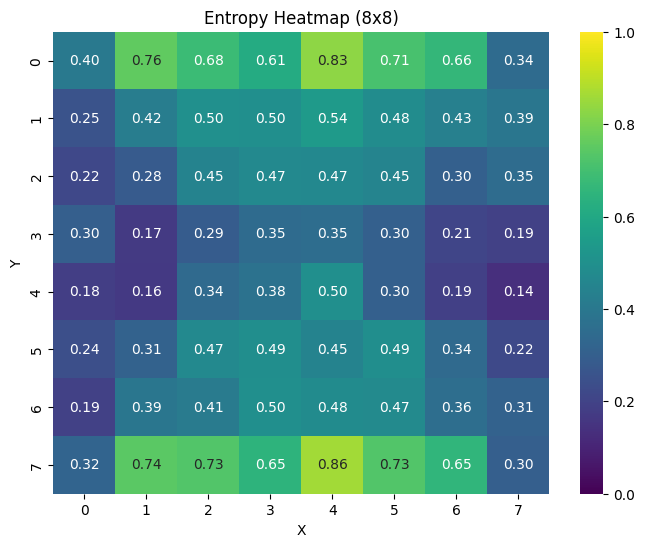

In [6]:
dataset = load_frecker_datasets(
    dataset_base_dir="/mnt/cdata/data/",
    iter_now=338,
    training_dataset_cross=2
)
snapshot = select_game_snapshot(dataset, 0)
map = get_entropy(snapshot, 0 , 1)


加载了 65080 个样本


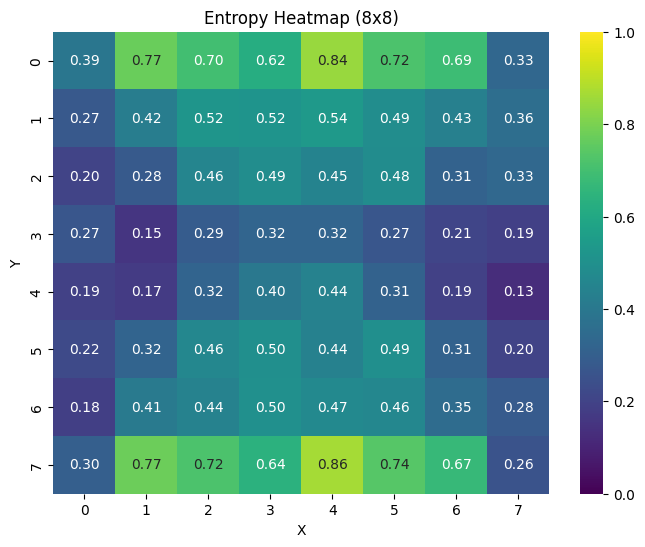

In [8]:
dataset = load_frecker_datasets(
    dataset_base_dir="/mnt/cdata/data/",
    iter_now=333,
    training_dataset_cross=1
)
snapshot = select_game_snapshot(dataset, 0)
map = get_entropy(snapshot, 0 ,1 )
